In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sys
sys.path.append('../')

import gen_synthetic_ts as gst

#### Generate synthetic time series

In [5]:
# get the synthetic timeserie

df_ts = gst.generate_synthetic_ts()
df_ts

,trend,seasonality,residual,DateTime,Value
0,0.000,5.082107,1.461450,2010-01-01,6.543557
1,0.001,5.279406,2.704887,2010-01-02,7.985293
2,0.002,5.463582,2.952176,2010-01-03,8.417758
3,0.003,5.631210,1.210661,2010-01-04,6.844871
4,0.004,5.779161,-0.196897,2010-01-05,5.586264
...,...,...,...,...,...
1455,1.455,14.655923,0.760019,2013-12-26,16.870942
1456,1.456,15.432413,0.793592,2013-12-27,17.682004
1457,1.457,16.201044,1.438552,2013-12-28,19.096596
1458,1.458,16.950705,2.640163,2013-12-29,21.048869


### Visualize time series componentes

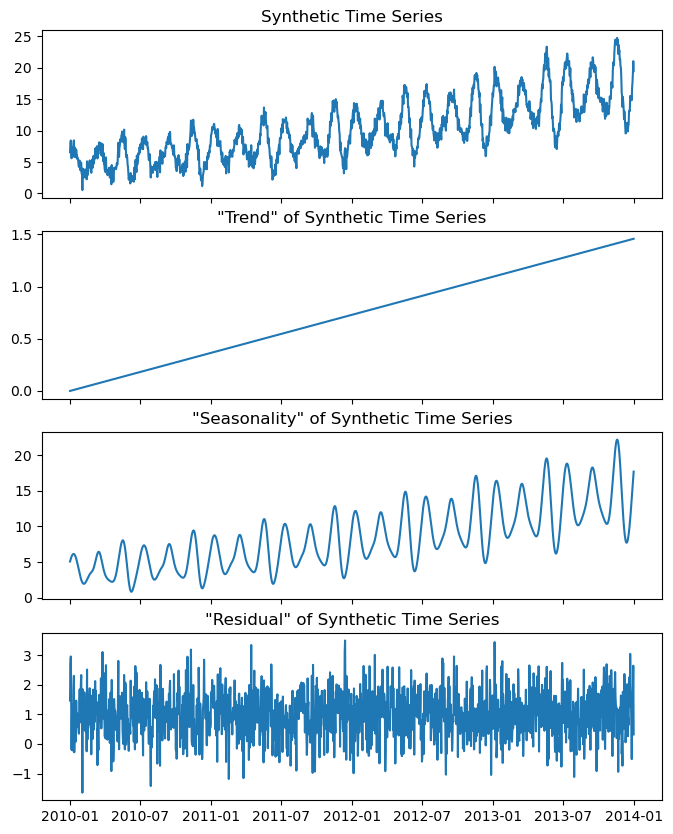

In [6]:
fig, axes = plt.subplots(figsize=(8, 10), nrows=4, ncols=1, sharex=True)

axes[0].plot(df_ts['DateTime'], df_ts['Value'])
axes[0].set_title('Synthetic Time Series')
axes[1].plot(df_ts['DateTime'], df_ts['trend'])
axes[1].set_title('"Trend" of Synthetic Time Series')
axes[2].plot(df_ts['DateTime'], df_ts['seasonality'])
axes[2].set_title('"Seasonality" of Synthetic Time Series')
axes[3].plot(df_ts['DateTime'], df_ts['residual'])
axes[3].set_title('"Residual" of Synthetic Time Series')
plt.show()

#### Apply Moving Average on (synthetic) time series

* we might be able to extract the trend using moving average if we are aware of the seasonality. We could choose window size equals to the seasonality and perform moving average to extract trend.
* This approach is, however, not very precise and has limitation such as 1. creating missing values at edges, 2. sensitive to outliers, 3. sensitive to rapid changes

> **Note:** Becareful of window size for calculating the moving average. If window size is an odd number, using `rolling` method from Pandas works quite well. However, in case of even number for window size, we need to slightly change the process of calculating moving average to end up with the right values as show in code cell below.

In [11]:
cols = ['DateTime', 'Value']

# compute moving averages
#window_size = 120  # common denomenator of 1/6, 1/8, and 1/10 from synthetic time serie)

def cal_moving_average(df_in: pd.DataFrame, window_size:int) -> pd.DataFrame:
    """ A function that receives input dataframe (with 'DateTime', and 'Value' columns), 
    and returns moving averaged of 'Value' column given window_size. 

    Args:
        df_in (pd.DataFrame): input dataframe that must have 'DateTime', and 'Value' columns
        window_size (int): window size for calculating moving average

    Returns:
        (pd.DataFrame): output dataframe with calculated moving average Value.
    """    
    if window_size % 2 == 0:
        # if window size is even
        movAvgDf = (
            df_in[cols]
            .set_index('DateTime')
            .rolling(
                window=window_size,
                center=False
            ).mean()
            .rolling(
                window=2,
                center=False
            ).mean()
            .shift(
                -window_size//2
            )
        )
    else:
        # if window size is odd
        movAvgDf = (
            df_in[cols]
            .set_index('DateTime')
            .rolling(
                window=window_size,
                center=True
            )
            .mean()
        )

    movAvgDf.rename(columns={'Value':f'{window_size}-MA'}, inplace=True)

    return movAvgDf

In [12]:
# calculate moving average for multiple window sizes and plot the results

window_size_lst = [6, 8, 10, 120]
mvaDF = []
for window_size in window_size_lst:
    mvaDF.append(cal_moving_average(df_ts, window_size))

mvaDF = pd.concat(mvaDF)
mvaDF

,6-MA,8-MA,10-MA,120-MA
DateTime,,,,
2010-01-01,NaN,NaN,NaN,NaN
2010-01-02,NaN,NaN,NaN,NaN
2010-01-03,NaN,NaN,NaN,NaN
2010-01-04,7.110725,NaN,NaN,NaN
2010-01-05,7.001616,NaN,NaN,NaN
...,...,...,...,...
2013-12-26,NaN,NaN,NaN,NaN
2013-12-27,NaN,NaN,NaN,NaN
2013-12-28,NaN,NaN,NaN,NaN


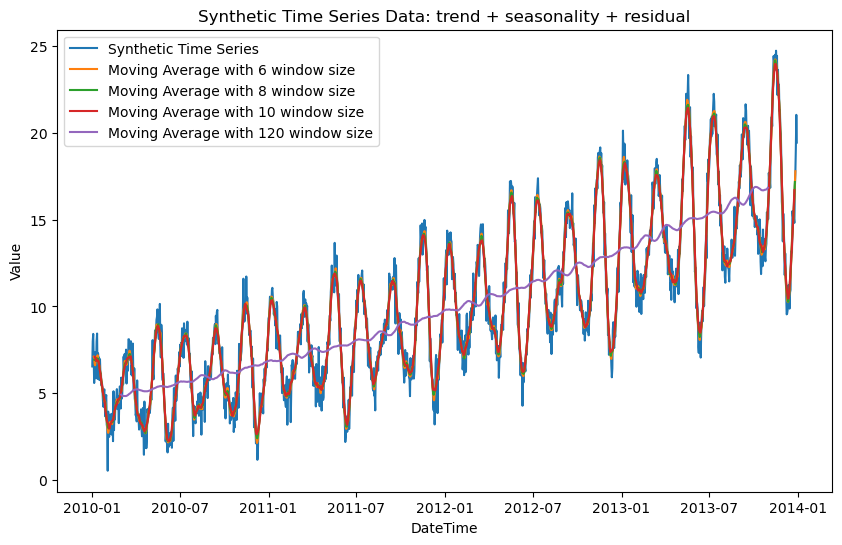

In [8]:
#Plot the synthetic time series
plt.figure(figsize=(10, 6))
plt.plot(df_ts['DateTime'], df_ts['Value'], label='Synthetic Time Series')

for window_size in window_size_lst:
    plt.plot(mvaDF.index, mvaDF[f'{window_size}-MA'], label=f'Moving Average with {window_size} window size')
plt.xlabel('DateTime')
plt.ylabel('Value')
plt.title('Synthetic Time Series Data: trend + seasonality + residual')
plt.legend()
plt.show()

#### Classical decomposition: Extract seasonality
Seasonality is extracted by de-trending and averaging over a known seasonal index (using moving average technique). This method is NOT reobust to outliers and assumes a fixed seasonal pattern: 

1. Outliers can distort the trend and hence also the estimated seasonal component
2. the classical approach for decomposing seasonality, trend and resdidual, assumes the seasonal component is fixed and does not change with time


**Since in our synthetic time serie, the seasonality is changing (and not fiexed) this apporach is not working on our case study**

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose

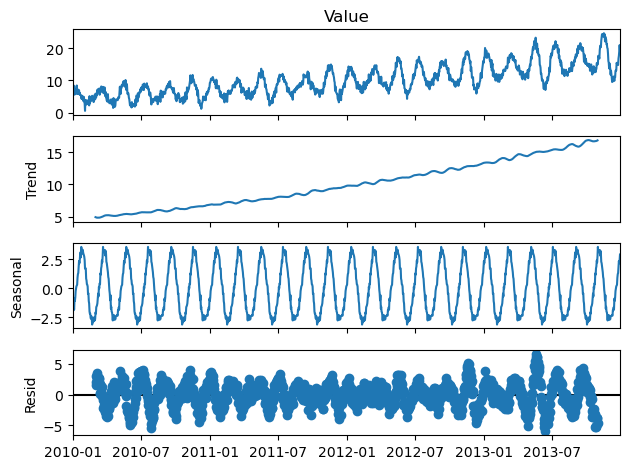

In [10]:
res = seasonal_decompose(
    x=df_ts.set_index('DateTime')['Value'],
    model='additive',
    period=120,
    two_sided=True
)
trend = res.trend
seasonal = res.seasonal
res.plot();

> **Note:** This classical apporach may not work if seasonality of time series is dynamic as we have in the current example. The amplitude of seasonality is changing by time and it is > increasing. Though as shown in graph below, the position of the min and max are relatively well determined, their dynamic behaviour is not.

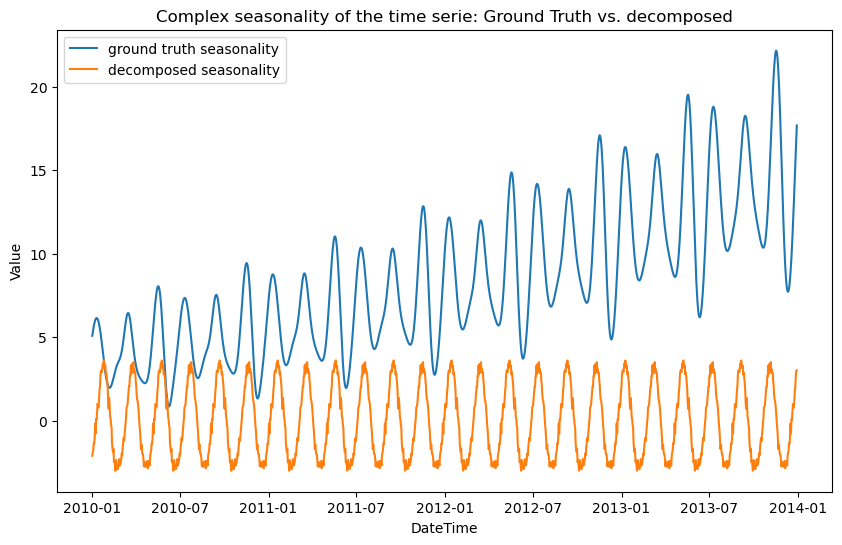

In [10]:
df_seas = pd.DataFrame(seasonality, columns=['Value'])
df_seas['DateTime'] = pd.date_range(start='2010-01-01', periods=total_points, freq='D')
df_seas = df_seas[['DateTime', 'Value']]  # Reordering columns for readability

#Plot the synthetic time series
plt.figure(figsize=(10, 6))
plt.plot(df_seas['DateTime'], df_seas['Value'], label='ground truth seasonality')
plt.plot(seasonal, label='decomposed seasonality')
plt.xlabel('DateTime')
plt.ylabel('Value')
plt.title('Complex seasonality of the time serie: Ground Truth vs. decomposed')
plt.legend()
plt.show()